# Analysing predicted poses for EPM

This notebook analyses predicted poses for a single mouse performing an elevated plus maze (EPM) task.

It first imports predicted poses from either [SLEAP](https://sleap.ai) or [DeepLabCut](https://www.mackenziemathislab.org/deeplabcut) using [movement](https://movement.neuroinformatics.dev/).

Subsequently, the following operations are performed on predicted poses:
- plot trajectories and confidence scores
- clean the imported pose tracks:
  - filter out low-confidence predictions
  - interpolate over missing points
  - smooth the tracks with a median filter
- compute time spent in different parts of the maze
- compute velocity, acceleration, and speed

## A. Setup
### A1. Create a conda environment and install required packages

In a terminal, clone the repository and go to the `notebooks` directory:
```bash
git clone https://github.com/neuroinformatics-unit/course-behavioural-analysis.git
cd course-behavioural-analysis/notebooks
```

Create a new conda environment and install required packages:
```bash
conda create -n epm-analysis -c conda-forge python=3.11 pip pytables
conda activate epm-analysis
pip install -r EPM_analysis_requirements.txt
```

Once all requirements are installed, you can open this notebook and select the `epm-analysis` kernel.

### A2. Import required packages

In [1]:
from pathlib import Path

import numpy as np
import xarray as xr
import yaml

from matplotlib import pyplot as plt

### A3. Specify paths to data

You should modify `DATA_DIR` to point to the directory where you downloaded the `mouse-EPM` folder containing the sample data.

The `derivatives` subfolder contains predictions from both SLEAP and DeepLabCut.
```bash
.
├── derivatives
│   └── behav
│       ├── software-DLC_predictions
│       └── software-SLEAP_project
│           └── predictions
│
└── rawdata
    ├── sub-01_ses-01_task-EPM_time-165049_video.mp4
    └── sub-02_ses-01_task-EPM_time-185651_video.mp4
```

- The SLEAP predictions were generated by Niko Sirmpilatze, based on only a few training examples.
- The DeepLabCut predictions were generated by Loukia Katsouri and should be of higher quality than the SLEAP predictions.

In [2]:
DATA_DIR = Path.home() / "Data" / "behav-analysis-course" / "mouse-EPM"

derivatives_dir = DATA_DIR / "derivatives"

# SLEAP predictions
sleap_predictions_dir = derivatives_dir / "software-SLEAP_project" / "predictions"
video1_sleap_preds_file = sleap_predictions_dir / "video-1.predictions.analysis.h5"
video2_sleap_preds_file = sleap_predictions_dir / "video-2.predictions.analysis.h5"

# DeepLabCut predictions
dlc_predictions_dir = derivatives_dir / "software-DLC_predictions"
video1_dlc_preds_file = dlc_predictions_dir / "sub-01_ses-01_task-EPM_time-165049_video_DLC_resnet50_MouseTopDownSep13shuffle1_340000_filtered.h5"
video2_dlc_preds_file = dlc_predictions_dir / "sub-02_ses-01_task-EPM_time-185651_video_DLC_resnet50_MouseTopDownSep13shuffle1_340000_filtered.h5"

# Frames (used as background for plotting)
video1_frame_file = dlc_predictions_dir / "sub-01_ses-01_task-EPM_time-170049_frame.png"
video2_frame_file = dlc_predictions_dir / "sub-02_ses-01_task-EPM_time-190651_frame.png"

Check that the above paths are correct by running the following cell:

In [3]:
for folder in [derivatives_dir, sleap_predictions_dir, dlc_predictions_dir]:
    assert folder.is_dir()

for file in [
    video1_sleap_preds_file,
    video2_sleap_preds_file,
    video1_dlc_preds_file,
    video2_dlc_preds_file,
    video1_frame_file,
    video2_frame_file,
]:
    assert file.is_file()

## B. Load and explore predictions

We'll need to import the `load_poses` module from `movement`.


In [4]:
from movement.io import load_poses  # noqa: E402

### B1. Load pose tracks with `movement`
The predicted pose tracks and the associated point-wise confidence scores are imported using [`movement`]((https://movement.neuroinformatics.dev/)) and represented as [xarray.Dataset](https://movement.neuroinformatics.dev/getting_started.html#dataset-structure) objects.

In [5]:
ds_sleap_video1 = load_poses.from_file(
    video1_sleap_preds_file,
    source_software="SLEAP",
    fps=30
)
ds_sleap_video1

<xarray.Dataset> Size: 1MB
Dimensions:      (time: 18485, individuals: 1, keypoints: 6, space: 2)
Coordinates:
  * time         (time) float64 148kB 0.0 0.03333 0.06667 ... 616.1 616.1 616.1
  * individuals  (individuals) <U12 48B 'individual_0'
  * keypoints    (keypoints) <U9 216B 'snout' 'left_ear' ... 'tail_end'
  * space        (space) <U1 8B 'x' 'y'
Data variables:
    position     (time, individuals, keypoints, space) float32 887kB nan ... ...
    confidence   (time, individuals, keypoints) float32 444kB nan nan ... 0.7607
Attributes:
    fps:              30.0
    time_unit:        seconds
    source_software:  SLEAP
    source_file:      /Users/nsirmpilatze/Data/behav-analysis-course/mouse-EP...
    ds_type:          poses

<div class="alert alert-block alert-info">

<b>Exercise 1: Loading pose tracks into movement</b>
- Load the DeepLabCut predictions for video1 (`sub-01`) into a `ds_dlc_video1` variable.
- Do you notice any differences between the SLEAP and DeepLabCut predictions?

**Hint:** consult the [Loading pose tracks](https://movement.neuroinformatics.dev/getting_started/input_output.html#loading-pose-tracks) section of the `movement` documentation.
</div>

In [6]:
ds_dlc_video1 = load_poses.from_file(
    video1_dlc_preds_file,
    source_software="DeepLabCut",
    fps=30
)
ds_dlc_video1

<xarray.Dataset> Size: 4MB
Dimensions:      (time: 18485, individuals: 1, keypoints: 8, space: 2)
Coordinates:
  * time         (time) float64 148kB 0.0 0.03333 0.06667 ... 616.1 616.1 616.1
  * individuals  (individuals) <U12 48B 'individual_0'
  * keypoints    (keypoints) <U13 416B 'snout' 'left_ear' ... 'tail_end'
  * space        (space) <U1 8B 'x' 'y'
Data variables:
    position     (time, individuals, keypoints, space) float64 2MB 508.3 ... ...
    confidence   (time, individuals, keypoints) float64 1MB 0.0002829 ... 0.9978
Attributes:
    fps:              30.0
    time_unit:        seconds
    source_software:  DeepLabCut
    source_file:      /Users/nsirmpilatze/Data/behav-analysis-course/mouse-EP...
    ds_type:          poses

Check that your solution is correct by running the following cell:

In [7]:
assert isinstance(ds_dlc_video1, xr.Dataset), "ds_dlc_video1 should exist and be an xarray Dataset"
assert ds_dlc_video1.source_software == "DeepLabCut", "ds_dlc_video1 should have source_software='DeepLabCut'"

### B2. Select subsets of the data
Below we get the "position" data variable for 3 keypoints: `["snout", "centre", "tail_base"]`

In [8]:
position_sleap_3kps = ds_sleap_video1.position.sel(keypoints=["snout", "centre", "tail_base"])
position_sleap_3kps

<xarray.DataArray 'position' (time: 18485, individuals: 1, keypoints: 3,
                              space: 2)> Size: 444kB
nan nan nan nan nan nan nan nan ... 384.0 684.7 504.8 667.8 440.0 636.8 384.1
Coordinates:
  * time         (time) float64 148kB 0.0 0.03333 0.06667 ... 616.1 616.1 616.1
  * individuals  (individuals) <U12 48B 'individual_0'
  * keypoints    (keypoints) <U9 108B 'snout' 'centre' 'tail_base'
  * space        (space) <U1 8B 'x' 'y'

<div class="alert alert-block alert-info">

<b>Exercise 2: Selecting subsets of data</b>

- Work with the `ds_dlc_video1` dataset you created in **Exercise 1**.
- Get the `confidence` data values for the `snout` keypoint, between time 2 and 4 minutes (inclusive), and store them in a variable called `snout_confidence`.

**Hint:** Consult the [Working with movement datasets](https://movement.neuroinformatics.dev/getting_started/movement_dataset.html#working-with-movement-datasets) section of the `movement` documentation.

</div>

In [9]:
snout_confidence = ds_dlc_video1.confidence.sel(
    keypoints="snout", time=slice(2*60, 4*60)
)
snout_confidence

<xarray.DataArray 'confidence' (time: 3601, individuals: 1)> Size: 29kB
0.9989 0.9998 0.9998 0.9998 0.9997 0.9995 ... 0.9419 0.9743 0.9883 0.9985 0.9992
Coordinates:
  * time         (time) float64 29kB 120.0 120.0 120.1 ... 239.9 240.0 240.0
  * individuals  (individuals) <U12 48B 'individual_0'
    keypoints    <U13 52B 'snout'

Check if your solution is correct by running the following cell:

In [10]:
assert isinstance(snout_confidence, xr.DataArray), "snout_confidence should exist and be an xarray DataArray"
assert snout_confidence.dims == ("time", "individuals"), "snout_confidence should have dims=('time', 'individuals')"
assert snout_confidence.shape[0] == 2 * 60 * 30 + 1, "snout_confidence should 3601 time points (2 minutes at 30 fps + 1)"

### B3. Plot keypoint trajectories and confidence scores over time
First we can plot the trajectories of the 3 keypoints we selected above over time (from the SLEAP predictions).

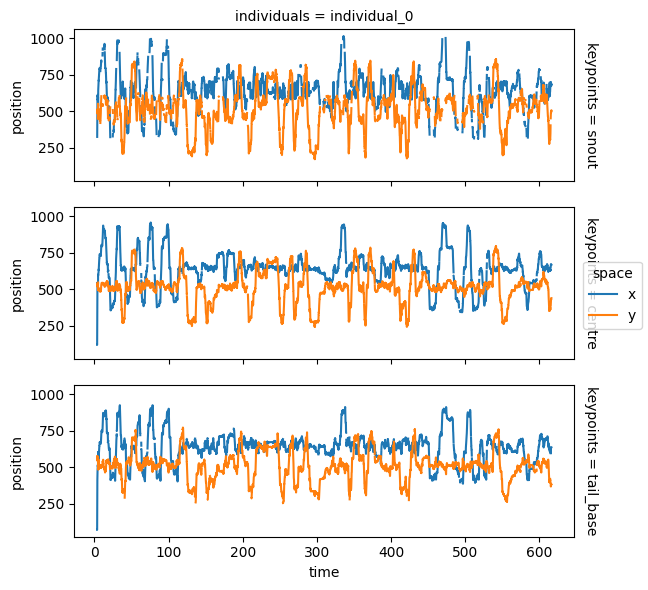

In [11]:
position_sleap_3kps.plot.line(
    x="time", row="keypoints", col="individuals", aspect=2.5, size=2
)

Now, we can plot the confidence scores for the same keypoints over time.

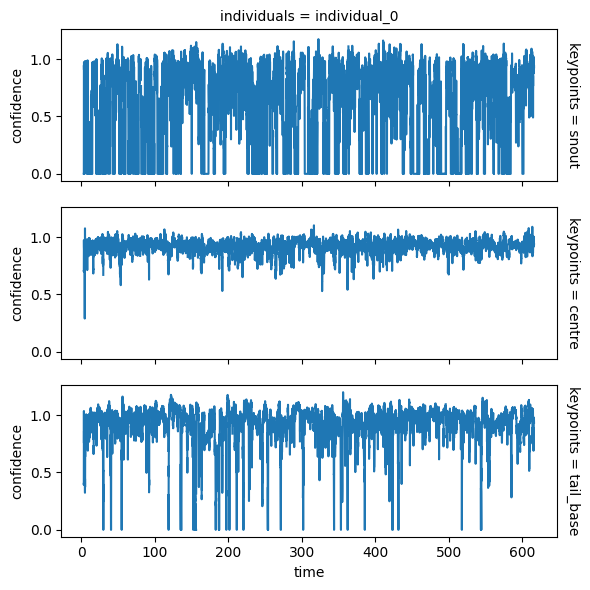

In [12]:
confidence_3kps = ds_sleap_video1.confidence.sel(keypoints=["snout", "centre", "tail_base"])
confidence_3kps.plot.line(
    x="time", row="keypoints", col="individuals", aspect=2.5, size=2,
)

<div class="alert alert-block alert-info">

<b>Exercise 3: Plotting with xarray</b>

- Work with the `ds_dlc_video1` dataset you created in **Exercise 1**.
- Get the `position` data values for the 3 keypoints `["snout", "centre", "tailbase"]` as `position_dlc_3kps`.
- Get the `confidence` data values for the 3 keypoints `["snout", "centre", "tailbase"]` as `confidence_dlc_3kps`.
- Plot the x,y positions and confidence scores for the 3 keypoints over time.
- What do you notice? How do they compare to the SLEAP pose tracks and confidence scores that we plotted above?

**Hint:** Consult the [Plotting](https://docs.xarray.dev/en/stable/user-guide/plotting.html) section of the `xarray` documentation.

</div>

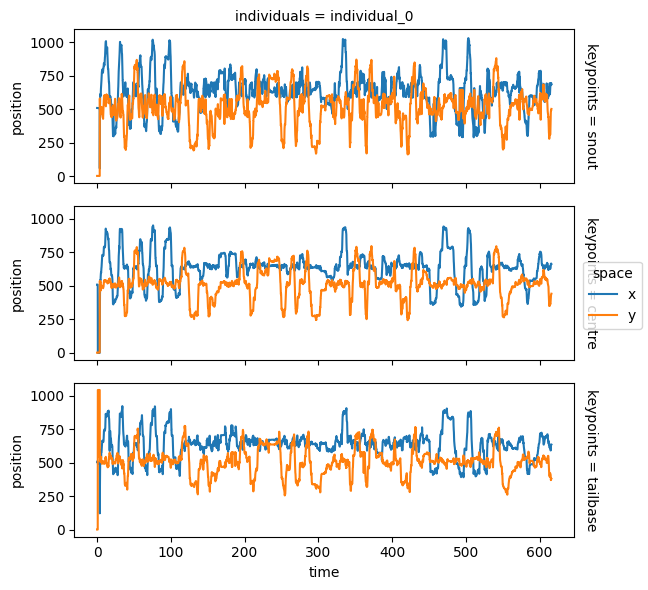

In [13]:
# Get and plot the pose tracks for the 3 keypoints from the DLC dataset
position_dlc_3kps = ds_dlc_video1.position.sel(keypoints=["snout", "centre", "tailbase"])
position_dlc_3kps.plot.line(x="time", row="keypoints", col="individuals", aspect=2.5, size=2)

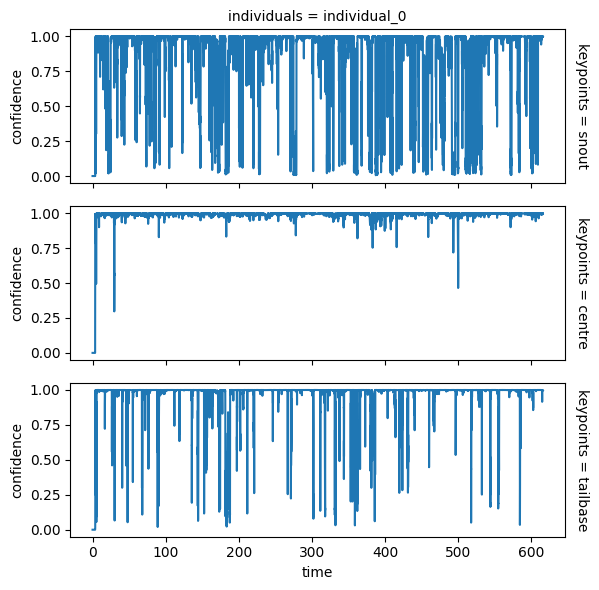

In [14]:
# Get and plot the confidence scores for the 3 keypoints from the DLC dataset
confidence_dlc_3kps = ds_dlc_video1.confidence.sel(keypoints=["snout", "centre", "tailbase"])
confidence_dlc_3kps.plot.line(x="time", row="keypoints", col="individuals", aspect=2.5, size=2)

Check if your solution is correct by running the following cell:

In [15]:
necessary_keypoints = ["snout", "centre", "tailbase"]
necessary_data_arrays = {"position_dlc_3kps": position_dlc_3kps, "confidence_dlc_3kps": confidence_dlc_3kps}
for var_name, data_array in necessary_data_arrays.items():
    assert isinstance(data_array, xr.DataArray), f"{var_name} should exist and be an xarray DataArray"
    assert all(
        k in data_array.keypoints.values for k in necessary_keypoints
    ), f"{var_name} should have keypoints={necessary_keypoints}"


### B4. Plot keypoint trajectories over the video frame
First, we load the video frame.

**Note:**  the relative position of the setup and the camera doesn't change between the two videos, so one frame can be used for both.

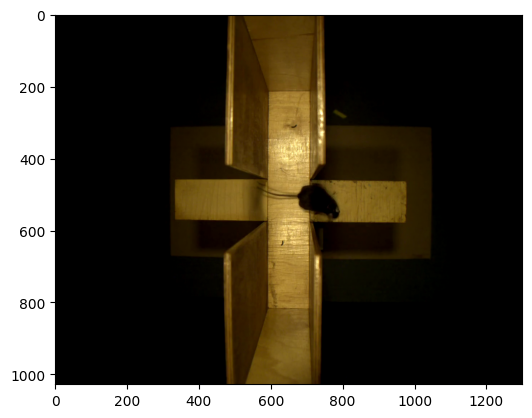

In [16]:
frame_img = plt.imread(video1_frame_file)
plt.imshow(frame_img);

Then we define a function to plot selected pose tracks over the video frame.

In [17]:
def plot_trajectory(
        data: xr.DataArray,
        individual: str,
        keypoint: str,
        time_range: tuple = None,
        frame: np.ndarray = None,
):
    """Plot trajectory of a single keypoint for a given individual.
    Optionally, the trajectory can be restricted to a time range and a frame
    can be shown as background.
    
    Parameters
    ----------
    data : xr.DataArray
        Array containing the position data.
    individual : str
        Name of the individual to plot.
    keypoint : str
        Name of the keypoint to plot.
    time_range : tuple, optional
        Start and end time of the trajectory to plot. If None, the entire
        trajectory will be plotted.
    frame : np.ndarray, optional
        Image to use as background. If None, the frame will not be shown.
    """
    
    # Aspects ratio of the frame (1 if no frame is provided)
    frame_aspect = 1 if frame is None else frame.shape[1] / frame.shape[0]

    # Create a new figure with an appropriate aspect ratio
    fig, ax = plt.subplots(figsize=(5 * frame_aspect, 5))

    # Show the frame, if provided
    if frame is not None:
        ax.imshow(frame)

    # Select the appropriate data
    data = data.sel(individuals=individual, keypoints=keypoint)
    if time_range is not None:
        data = data.sel(time=slice(*time_range))
        
    plt.scatter(
        data.sel(space="x"), data.sel(space="y"), s=1, c=data.time, cmap="viridis"
    )
    plt.title(f"Trajectory of {individual} {keypoint}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar(label="time (s)")

    fig.tight_layout()

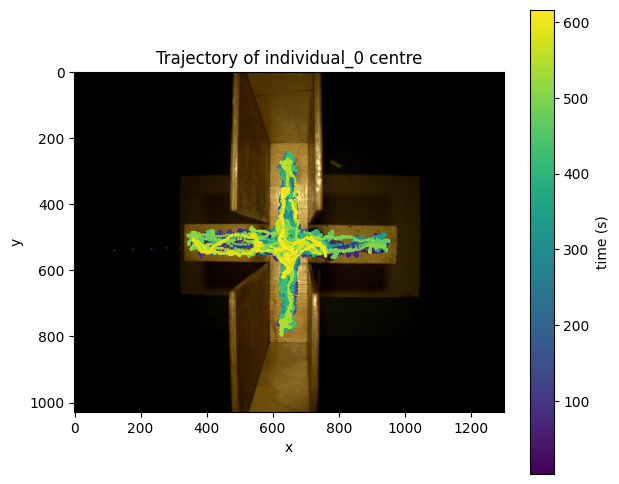

In [18]:
plot_trajectory(
    ds_sleap_video1.position,
    individual="individual_0",
    keypoint="centre",
    frame=frame_img,
)

<div class="alert alert-block alert-info">

<b>Exercise 4: Trajectory plots</b>

- Work with the `ds_dlc_video1` dataset you created in **Exercise 1**.
- Use the `plot_trajectory()` function to plot the pose tracks for `individual_0`  and keypoint `snout` over the entire time range.
- Use the `plot_trajectory()` function again but restrict the time range to (1-10) minutes.
- What is different between the two plots? Why?
- Now plot the trajectory for the `tailbase` keypoint the time range to (1-10) minutes, what is the difference to the `snout` trajectory?

</div>

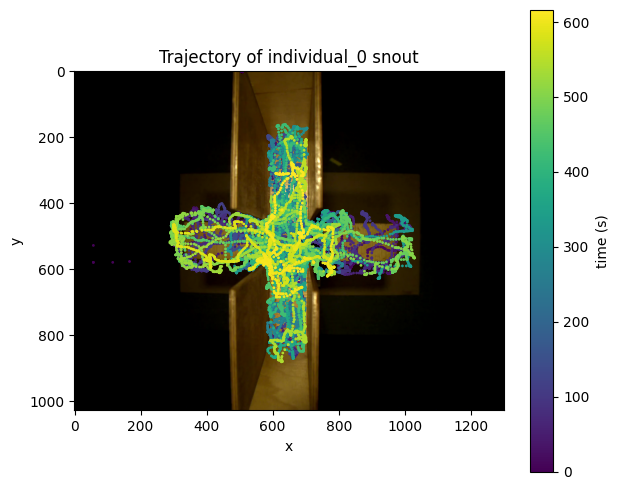

In [19]:
# snout trajectory plot for the entire time range
plot_trajectory(
    ds_dlc_video1.position,
    individual="individual_0",
    keypoint="snout",
    frame=frame_img,
)

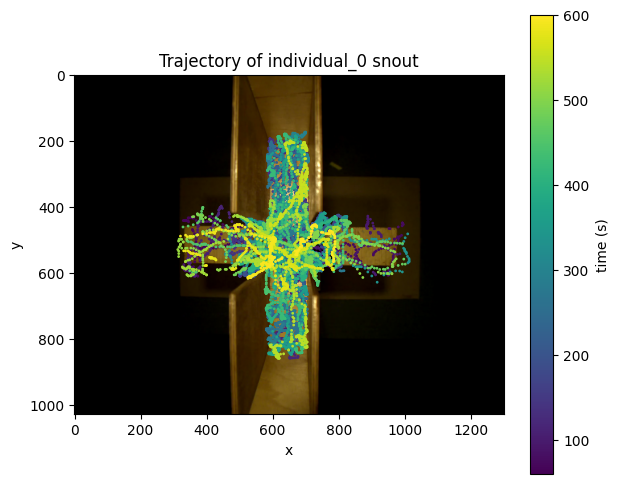

In [21]:
# snout trajectory plot for the time range 1-10 minutes
plot_trajectory(
    ds_sleap_video1.position,
    individual="individual_0",
    keypoint="snout",
    time_range=(1*60, 10*60),
    frame=frame_img,
)

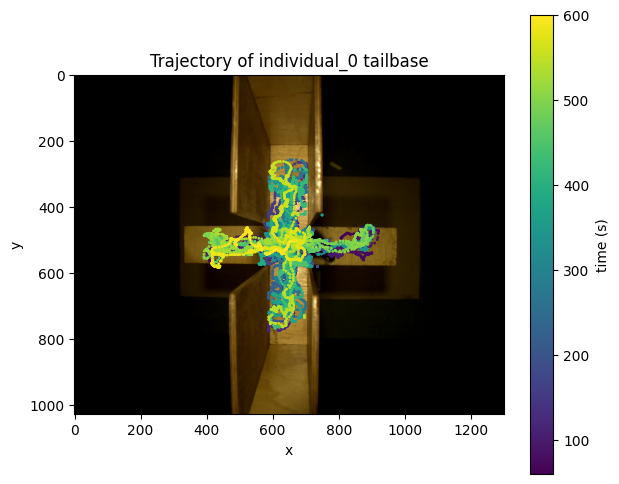

In [23]:
# tailbase trajectory plot for the time range 1-10 minutes
plot_trajectory(
    ds_dlc_video1.position,
    individual="individual_0",
    keypoint="tailbase",
    time_range=(1*60, 10*60),
    frame=frame_img,
)


## C. Data cleaning

We will need to import several functions from the `filtering` module of `movement`.

In [24]:
from movement.filtering import (  # noqa: E402
    filter_by_confidence, interpolate_over_time, median_filter
)

### C1. Discard points with low confidence scores
We can filter out low-confidence points from the trajectories, by setting their values to `NaN`.

However, we should be careful with choosing a threshold for the confidence score, which may depend on the software used to generate the predictions.

First, let's plot the histograms of confidence scores to get an idea of how they are distributed.

In [25]:
# All keypoint names in the SLEAP dataset
sleap_kpts = ds_sleap_video1.keypoints.values
# Take colors from the "tab10" colormap
colors = plt.cm.tab10.colors

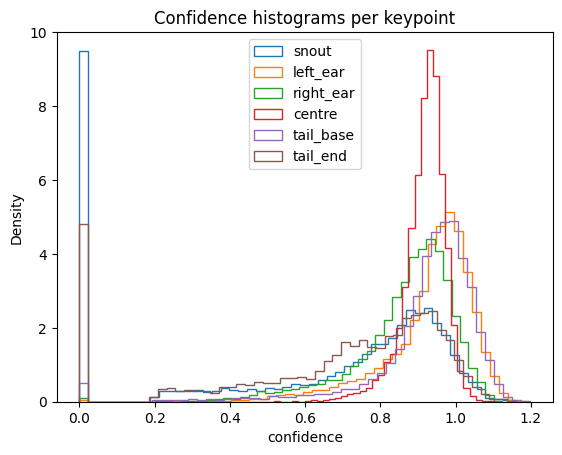

In [26]:
# Create a new figure with confidence histograms for each keypoint
fig, ax = plt.subplots()
for kp, color in zip(sleap_kpts, colors):
    data = ds_sleap_video1.confidence.sel(keypoints=kp)
    data.plot.hist(
        bins=50, histtype="step", density=True, ax=ax, color=color, label=kp
    )
ax.set_ylabel("Density")
ax.set_title("Confidence histograms per keypoint")
plt.legend()

As we can see, the confidence score distributions differ widely across keypoints, as some keypoints (e.g. `centre`) are easier to detect than others (e.g. `tail_end`).

For the following steps, we arbitrarily choose a threshold of 0.6, i.e. points with confidence scores below 0.6 will be excluded from the trajectories.

In [27]:
# Set all position values below the confidence threshold to NaN
# The thesholded data will be stored in a new data variable
# called "position_thresh"
ds_sleap_video1["position_thresh"] = filter_by_confidence(
    ds_sleap_video1.position, ds_sleap_video1.confidence, threshold=0.6
)


Missing points (marked as NaN) in input
	Individual: individual_0
		snout: 4494/18485 (24.3%)
		left_ear: 513/18485 (2.8%)
		right_ear: 533/18485 (2.9%)
		centre: 490/18485 (2.7%)
		tail_base: 704/18485 (3.8%)
		tail_end: 2496/18485 (13.5%)

Missing points (marked as NaN) in output
	Individual: individual_0
		snout: 6866/18485 (37.1%)
		left_ear: 1017/18485 (5.5%)
		right_ear: 1497/18485 (8.1%)
		centre: 499/18485 (2.7%)
		tail_base: 1329/18485 (7.2%)
		tail_end: 5593/18485 (30.3%)


In [28]:
ds_sleap_video1

<xarray.Dataset> Size: 2MB
Dimensions:          (time: 18485, individuals: 1, keypoints: 6, space: 2)
Coordinates:
  * time             (time) float64 148kB 0.0 0.03333 0.06667 ... 616.1 616.1
  * individuals      (individuals) <U12 48B 'individual_0'
  * keypoints        (keypoints) <U9 216B 'snout' 'left_ear' ... 'tail_end'
  * space            (space) <U1 8B 'x' 'y'
Data variables:
    position         (time, individuals, keypoints, space) float32 887kB nan ...
    confidence       (time, individuals, keypoints) float32 444kB nan ... 0.7607
    position_thresh  (time, individuals, keypoints, space) float32 887kB nan ...
Attributes:
    fps:              30.0
    time_unit:        seconds
    source_software:  SLEAP
    source_file:      /Users/nsirmpilatze/Data/behav-analysis-course/mouse-EP...
    ds_type:          poses

### C2. Interpolate over missing points
Sometimes a keypoint may disappear for a few frames, e.g. if it's occluded by another object.

We can "fill in" the missing points by interpolating over short gaps. Interpolating over longer gaps may lead to inaccurate results, as the uncertainty about the position of the keypoint increases.

Below we will use linear interpolation, but other methods are available (see [xarray.DataArray.interpolate_na](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.interpolate_na.html)). We will set the maximum gap length to 30 frames (1 second), but feel free to experiment with other values.
We can plot the trajectories again to see the effect of interpolation.

In [29]:
# interpolate over missing values (NaNs) in the thesholded position for gaps of up to max_gap frames
# The interpolated data will be stored in a new variable called "position_interp"
ds_sleap_video1["position_interp"] = interpolate_over_time(
    ds_sleap_video1.position_thresh, method="linear", max_gap=30
)


Missing points (marked as NaN) in input
	Individual: individual_0
		snout: 6866/18485 (37.1%)
		left_ear: 1017/18485 (5.5%)
		right_ear: 1497/18485 (8.1%)
		centre: 499/18485 (2.7%)
		tail_base: 1329/18485 (7.2%)
		tail_end: 5593/18485 (30.3%)

Missing points (marked as NaN) in output
	Individual: individual_0
		snout: 4602/18485 (24.9%)
		left_ear: 302/18485 (1.6%)
		right_ear: 524/18485 (2.8%)
		centre: 256/18485 (1.4%)
		tail_base: 513/18485 (2.8%)
		tail_end: 3297/18485 (17.8%)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


You can find out more on this topic by going through the
[Drop outliers and interpolate](https://movement.neuroinformatics.dev/examples/filter_and_interpolate.html)
example in the `movement` documentation.

### C3. Smooth trajectories

Because poses are predicted on a frame-by-frame basis, and only later
stitched together into tracks, we often find artifactual jitter in the
trajectories. We can get rid of this jitter by smoothing the data over time.
Here, we will apply a median filter with a rolling window of 5 frames
to the interpolated dataset.

In [30]:
ds_sleap_video1["position_smooth"] = median_filter(
    ds_sleap_video1.position_interp, window=5
)


Missing points (marked as NaN) in input
	Individual: individual_0
		snout: 4602/18485 (24.9%)
		left_ear: 302/18485 (1.6%)
		right_ear: 524/18485 (2.8%)
		centre: 256/18485 (1.4%)
		tail_base: 513/18485 (2.8%)
		tail_end: 3297/18485 (17.8%)

Missing points (marked as NaN) in output
	Individual: individual_0
		snout: 4850/18485 (26.2%)
		left_ear: 324/18485 (1.8%)
		right_ear: 560/18485 (3.0%)
		centre: 274/18485 (1.5%)
		tail_base: 551/18485 (3.0%)
		tail_end: 3503/18485 (19.0%)


You will notice that the number of NaN values in the dataset has somewhat
increased. Can you guess why?

You can learn about this and other smoothing-related issues,
by going through the
[Smooth pose tracks](https://movement.neuroinformatics.dev/examples/smooth.html)
example in the `movement` documentation.

### C4. Visualise the effects of data cleaning

We will plot the pose track of the `snout` keypoint before and after each 
data cleaning step to evaluate the effects of each step.
For illustration purposes, we will focus on a small time range.

In [31]:
def plot_multiple_position_vars(
    ds: xr.Dataset,
    data_vars: list,
    selection: dict
):
    """Plot multiple position variables from a dataset.

    Parameters
    ----------
    ds : xr.Dataset
        Dataset containing the position variables.
    data_vars : list
        List of variable names to plot.
    selection : dict
        Dictionary of selection criteria to apply to the data.
        Must select 1 individual, 1 keypoint, 1 space coordinate,
        and, optionally, a time range.
    """
    n_vars = len(data_vars)

    space_coord = selection["space"]
    kpt_name = selection["keypoints"]
    ind_name = selection["individuals"]
    colors = plt.cm.tab10.colors

    fig, axs = plt.subplots(
        n_vars, 1, figsize=(8, n_vars * 2 + 2), sharex=True, sharey=True
    )
    for i, var in enumerate(data_vars):
        data = ds[var].sel(**selection)

        ax = axs[i]
        ax.plot(data.time, data, label=var, color=colors[i])
        ax.set_title(f"{var} for {ind_name} {kpt_name}")
        ax.set_ylabel(f"{space_coord} position")
    ax.set_xlabel("time (s)")

    fig.tight_layout()


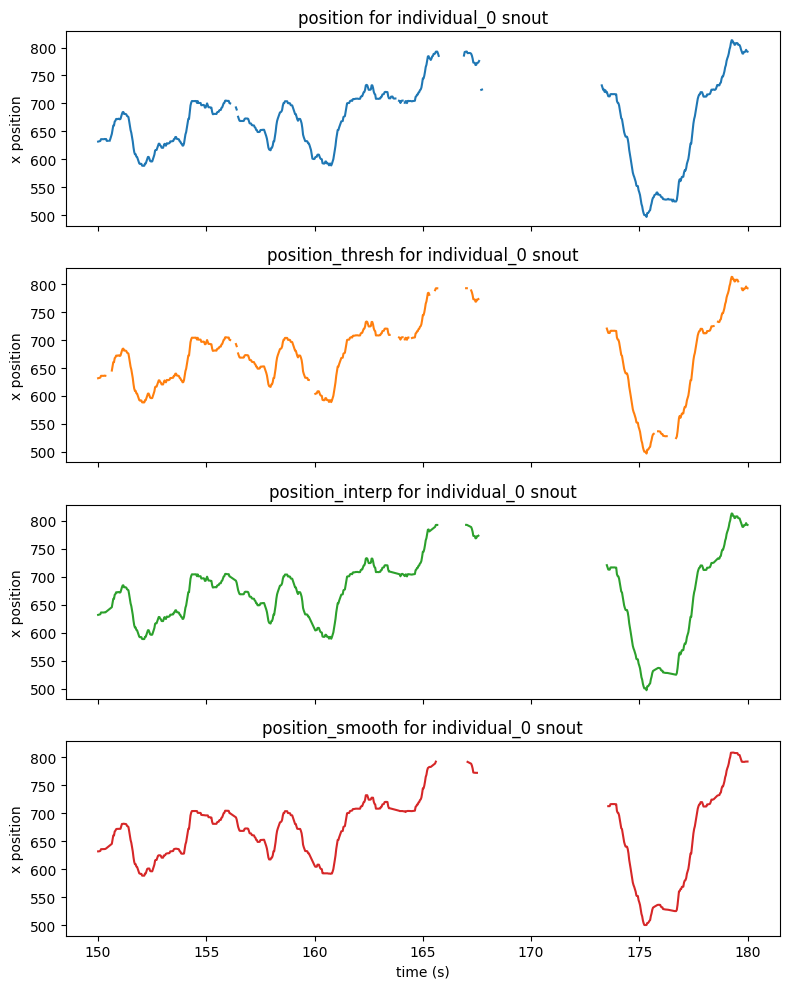

In [32]:
# Variable names storing the different data arrays
data_vars = [
    "position", "position_thresh", "position_interp", "position_smooth"
]

# Select a subset of the data for plotting
selection = {
    "keypoints": "snout",
    "individuals": "individual_0",
    "space": "x",
    "time": slice(2.5 * 60, 3 * 60), # focus on 2.5-3 minutes
}

plot_multiple_position_vars(
    ds_sleap_video1, data_vars, selection
)

<div class="alert alert-block alert-info">

<b>Exercise 5: Data cleaning</b>

- Repeat the above filtering and interpolation procedure for the `ds_dlc_video1` dataset you loaded in **Exercise 1**.
- Plot the confidence score histograms to select a threshold for filtering.
- Sequentially apply the filtering, interpolation and smoothing steps.
- Experiment with various thresholds, interpolation methods, gap lengths and window sizes.
- Visualise the data at each processing step (feel free to reuse the `plot_multiple_position_vars()` function).

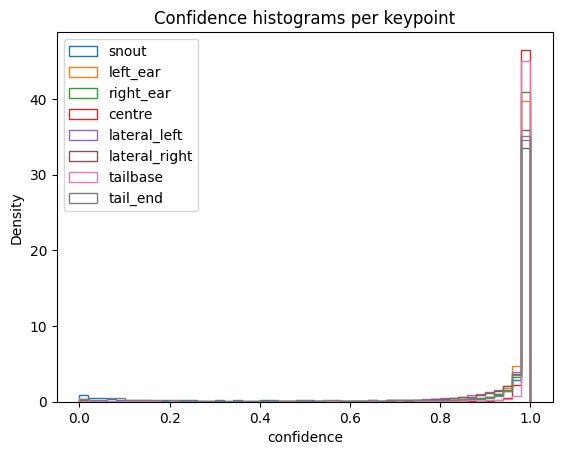

In [33]:
# Plot the confidence score histograms for the DeepLabCut dataset
dlc_kpts = ds_dlc_video1.keypoints.values

fig, ax = plt.subplots()
for kp, color in zip(dlc_kpts, colors):
    data = ds_dlc_video1.confidence.sel(keypoints=kp)
    data.plot.hist(
        bins=50, histtype="step", density=True, ax=ax, color=color, label=kp
    )
ax.set_ylabel("Density")
ax.set_title("Confidence histograms per keypoint")
plt.legend()

In [36]:
# Sequentially apply the confidence filtering, interpolation, and smoothing
# steps to the DeepLabCut dataset

dlc_conf_thresh = 0.95  # use much higher confidence threshold for DLC
print(f"Applying a confidence threshold of {dlc_conf_thresh} to the DLC dataset")
ds_dlc_video1["position_thresh"] = filter_by_confidence(
    ds_dlc_video1.position, ds_dlc_video1.confidence, threshold=dlc_conf_thresh
)

dlc_max_gap = 30  # frames
print(
    "\nInterpolating over missing values in the thresholded position data "
    f"for gaps of up to {dlc_max_gap} frames"
)
ds_dlc_video1["position_interp"] = interpolate_over_time(
    ds_dlc_video1.position_thresh, method="linear", max_gap=dlc_max_gap
)

dlc_window = 5  # frames
print(
    f"\nApplying a median filter with a window size of {dlc_window} "
    "to the interpolated position data"
) 
ds_dlc_video1["position_smooth"] = median_filter(
    ds_dlc_video1.position_interp, window=dlc_window
)

Applying a confidence threshold of 0.95 to the DLC dataset

Missing points (marked as NaN) in input
	Individual: individual_0
		snout: 0/18485 (0.0%)
		left_ear: 0/18485 (0.0%)
		right_ear: 0/18485 (0.0%)
		centre: 0/18485 (0.0%)
		lateral_left: 0/18485 (0.0%)
		lateral_right: 0/18485 (0.0%)
		tailbase: 0/18485 (0.0%)
		tail_end: 0/18485 (0.0%)

Missing points (marked as NaN) in output
	Individual: individual_0
		snout: 4728/18485 (25.6%)
		left_ear: 1671/18485 (9.0%)
		right_ear: 1819/18485 (9.8%)
		centre: 373/18485 (2.0%)
		lateral_left: 3795/18485 (20.5%)
		lateral_right: 3443/18485 (18.6%)
		tailbase: 1478/18485 (8.0%)
		tail_end: 3885/18485 (21.0%)

Interpolating over missing values in the thresholded position data for gaps of up to 30 frames

Missing points (marked as NaN) in input
	Individual: individual_0
		snout: 4728/18485 (25.6%)
		left_ear: 1671/18485 (9.0%)
		right_ear: 1819/18485 (9.8%)
		centre: 373/18485 (2.0%)
		lateral_left: 3795/18485 (20.5%)
		lateral_right: 3443/1

## D. Compute time spent in different parts of the maze

### D1. Define regions of interest (ROIs)

First we will have to define the different parts of the maze and their coordinates as ROIs:

- `open_arm_left`
- `open_arm_right`
- `closed_arm_bottom`
- `closed_arm_top`
- `central_square`

Each ROI is defined as a polygon consisting of a list of vertex coordinates.
In the cell below, we load this coordinates from the provided `EPM_rois.yaml`
file into a Python dictionary mappring ROI names to their vertex coordinates.

In practice, you would have to define these coordinates using tools such
as [ImageJ](https://imagej.net/ij/) or [napari](https://napari.org/)
and then import them into Python.
ROI definition functionality is also planned for a [future version of `movement`](https://movement.neuroinformatics.dev/community/roadmaps.html).

In [37]:
with open("EPM_rois.yaml", 'r') as file:
    rois = yaml.safe_load(file)

print(rois)

{'open_arm_left': [[323, 452], [412, 447], [511, 449], [591, 458], [591, 575], [522, 588], [416, 586], [324, 581], [322, 516], [323, 452]], 'open_arm_right': [[707, 460], [793, 449], [893, 452], [983, 453], [986, 515], [984, 587], [899, 590], [791, 589], [705, 577], [707, 460]], 'closed_arm_bottom': [[592, 574], [706, 576], [714, 643], [711, 740], [711, 829], [642, 828], [583, 827], [579, 749], [580, 659], [592, 574]], 'closed_arm_top': [[587, 198], [651, 196], [716, 201], [717, 291], [721, 383], [707, 458], [590, 457], [579, 381], [580, 278], [587, 198]], 'central_square': [[591, 458], [707, 459], [707, 576], [590, 575], [591, 458]]}


First, let's plot the ROIs on top of the video frame, to make sure we've got the coordinates right.

In [38]:
def plot_rois_on_frame(frame: np.ndarray, rois: dict):
    """Plot ROI coordinates on top of a frame.
    
    Parameters
    ----------
    frame : np.ndarray
        Frame to plot.
    roi_coords : dict
        dictionary mapping ROI names to 2D coordinates (x, y) in pixels.
    """
    
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(frame)
    for roi_name, roi_coords in rois.items():
        ax.plot(*np.array(roi_coords).T, lw=2, label=roi_name)
    ax.axis("off")
    ax.legend()

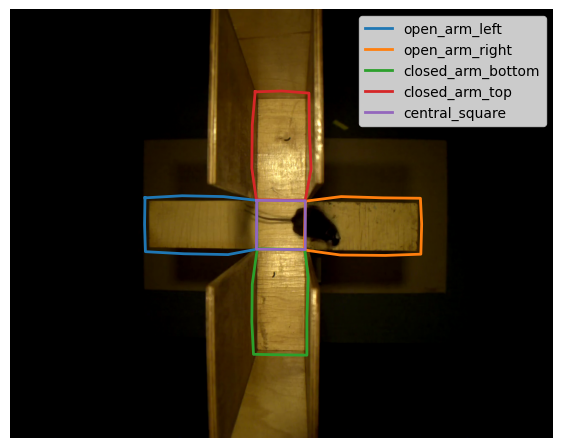

In [39]:
plot_rois_on_frame(frame_img, rois)

### D2. Compute time spent in each ROI

First we define some helper functions which determine if a set of points is inside a polygon,
either for a single frame or frame-by-frame.

We will use the `Point` and `Polygon` classes from the [`shapely`](https://shapely.readthedocs.io/en/stable/index.html) package.

In [40]:
from shapely.geometry import Polygon, Point  # noqa: E402

In [41]:
def polygon_contains_all_points(
    roi_polygon: Polygon,
    points: np.ndarray,
) -> bool:
    """Return true if all points are within a polygon.
    
    Parameters
    ----------
    roi_polygon : shapely.geometry.Polygon
        Polygon to check.
    points : np.ndarray
        2D array of (x, y) points to check.

    Returns
    -------
    bool
        True if all points are within the polygon.
    """
    return np.all([roi_polygon.contains(Point(point)) for point in points])


def polygon_contains_all_points_framewise(
    roi_polygon: Polygon,
    point_timeseries: np.ndarray,
) -> np.ndarray:
    """
    Return a boolean mask indicating whether all points are within the polygon
    for each frame.

    Parameters
    ----------
    roi_polygon : shapely.geometry.Polygon
        Polygon to check.
    point_timeseries : np.ndarray
        3D array of (n_frames, x, y) points to check.
    
    Returns
    -------
    np.ndarray
        Boolean mask indicating whether all points are within the polygon
        for each frame.
    """
    return np.array(
            [polygon_contains_all_points(roi_polygon, fr) for fr in point_timeseries]
        )


# sanity check
test_polygon = Polygon([[0, 0], [1, 0], [1, 1], [0, 1]])  # unit square
test_point_timeseries = np.array([
    # all points are inside the square for the first frame
    [[0.5, 0.5], [0.6, 0.3], [0.2, 0.7]],
    # one point is outside the square for the second frame
    [[1.5, 1.5], [0.6, 0.3], [0.2, 0.7]],
])
test_array = polygon_contains_all_points_framewise(test_polygon, test_point_timeseries)
assert np.all(test_array == np.array([True, False]))

Now we can compute which ROI was occupied at each frame, and derive the relative time spent in open vs closed arms.

In [42]:
def open_to_closed_arms_ratio(
    data: xr.DataArray,
    rois: dict,
    individual: str,
    needed_keypoints: list,
    time_range: tuple | None = None,
) -> float:
    """
    Calculate the ratio of time spent in open arms vs closed arms.

    Parameters
    ----------
    data : xr.DataArray
        Array contain position data.
    rois : dict
        Dictionary mapping ROI names to 2D coordinates (x, y) in pixels.
    individual : str
        Name of the individual
    needed_keypoints : list
        List of keypoints that must be within the ROI
    time_range : tuple, optional
        Start and end time of the trajectory to plot (in seconds).
        If None, the entire trajectory will be plotted.

    Returns
    -------
    float
        Ratio of time spent in open arms vs closed arms.
    """

    # Convert ROI coordinates to Shapely polygons
    roi_polygons = {roi_name: Polygon(roi_coords) for roi_name, roi_coords in rois.items()}

    # Select the appropriate data
    data = data.sel(individuals=individual, keypoints=needed_keypoints)
    if time_range is not None:
        data = data.sel(time=slice(*time_range))

    # Calculate the boolean mask for each ROI (True if all needed keypoints are within the ROI)
    roi_masks = {
        roi_name: polygon_contains_all_points_framewise(roi_polygon, data.values)
        for roi_name, roi_polygon in roi_polygons.items()
    }

    # Calculate the ratio of frames spent in open vs closed arms
    num_frames_in_open = (roi_masks["open_arm_left"] | roi_masks["open_arm_right"]).sum()
    num_frames_in_closed = (roi_masks["closed_arm_top"] | roi_masks["closed_arm_bottom"]).sum()

    return num_frames_in_open / num_frames_in_closed


In [43]:
result_sleap_video1 = open_to_closed_arms_ratio(
    ds_sleap_video1.position_smooth,  # use the "clean" position data
    rois=rois,
    individual="individual_0",
    needed_keypoints=["centre"],
    time_range=(1 * 60, 10 * 60)
)

print("Open to closed arms ratio:", result_sleap_video1)

Open to closed arms ratio: 1.0581512605042016


## E. Put it all together

Combine the above steps into a single function that takes as input an xarray dataset containing predicted poses and outputs the ratio of time spent in open vs closed arms.

Optionally, you can also plot a keypoint trajectory over the video frame.

In [44]:
def analyse_video_predictions(
        ds: xr.Dataset,
        time_range: tuple,
        rois: dict,
        individual: str,
        needed_keypoints: list,
        confidence_threshold: float = 0.6,
        interp_max_gap: float = 30,
        median_filter_window: int = 5,
        plot: bool = False,
        plot_keypoint: str = "centre",
        plot_frame: np.ndarray = None,
) -> float:

    # restrict to time range, if provided
    if time_range:
        ds = ds.sel(time=slice(*time_range))
    
    # filter by confidence threshold
    ds["position_thresh"] = filter_by_confidence(
        ds.position, ds.confidence, threshold=confidence_threshold, print_report=False
    )
    # interpolate over missing values (NaNs) for gaps of up to max_gap seconds
    ds["position_interp"] = interpolate_over_time(
        ds.position_thresh, method="linear", max_gap=interp_max_gap, print_report=False
    )
    # apply median filter to smooth the data
    ds["position_smooth"] = median_filter(
        ds.position_interp, window=median_filter_window, print_report=False
    )

    if plot:
        plot_trajectory(
            ds.position_smooth,
            individual=individual,
            keypoint=plot_keypoint,
            frame=plot_frame,
        )

    # calculate the ratio of time spent in open vs closed arms
    return open_to_closed_arms_ratio(
        ds.position_smooth,
        rois=rois,
        individual=individual,
        needed_keypoints=needed_keypoints,
    )


For example this is how we can apply the function to the second video's SLEAP predictions:

Open to closed arms ratio: 1.6407864885303756


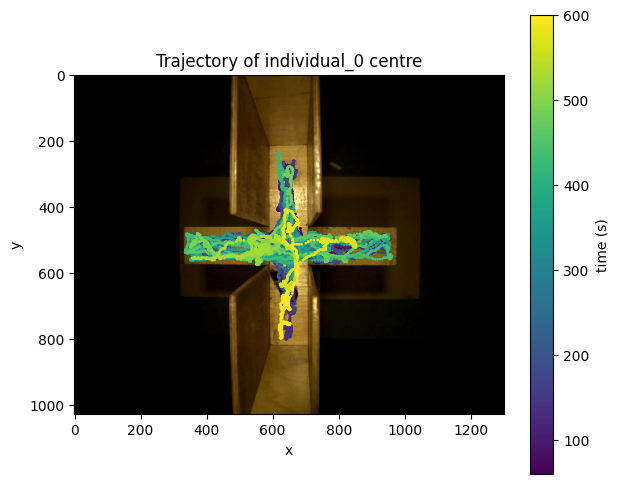

In [45]:
ds_sleap_video2 = load_poses.from_file(
    video2_sleap_preds_file, source_software="SLEAP", fps=30
)

result_sleap_video2 = analyse_video_predictions(
    ds_sleap_video2,
    time_range=(1 * 60, 10 * 60),
    rois=rois,
    individual="individual_0",
    needed_keypoints=["centre", "tail_base"],
    confidence_threshold=0.6,
    interp_max_gap=30,
    median_filter_window=5,
    plot=True,
    plot_keypoint="centre",
    plot_frame=plt.imread(video2_frame_file),
)

print("Open to closed arms ratio:", result_sleap_video2)

<div class="alert alert-block alert-info">

<b>Exercise 5: Compute time spent in open vs closed arms</b>

- Use the `analyse_video_predictions()` function to compute the ratio of time spent in open vs closed arms for each video and software package.
- Which mouse (`sub-01` or `sub-02`) was more anxious? Do SLEAP and DeepLabCut agree?


In [49]:
common_parameters = {
    "time_range": (1 * 60, 10 * 60),
    "rois": rois,
    "individual": "individual_0",
    "needed_keypoints": ["centre"],
    "interp_max_gap": 30,
    "median_filter_window": 5,
    "plot": False,
}

ds_dlc_video2 = load_poses.from_file(
    video2_dlc_preds_file, source_software="DeepLabCut", fps=30
)

print("DLC results:")
for i, dlc_video in enumerate([ds_dlc_video1, ds_dlc_video2]):
    result_dlc = analyse_video_predictions(
        dlc_video,
        confidence_threshold=0.95,
        **common_parameters
    )
    print(f"\tVideo {i+1}: ", result_dlc)

print("SLEAP results:")
for i, sleap_video in enumerate([ds_sleap_video1, ds_sleap_video2]):
    result_sleap = analyse_video_predictions(
        sleap_video,
        confidence_threshold=0.6,
        **common_parameters
    )
    print(f"\tVideo {i+1}: ", result_sleap)

DLC results:
	Video 1:  1.0959810072918432
	Video 2:  1.785345021353113
SLEAP results:
	Video 1:  1.0581512605042016
	Video 2:  1.7210087818058997


**Conclusion:**
- Analysis results are quite consistent between DeepLabCut and SLEAP.
- `sub-02` (from Video 2) spent much more time in the open arms than `sub-01` (from Video 1), suggesting that `sub-02` was less anxious / more exploratory.

## F. Bonus: Compute kinematics

`movement` also provides functions to compute velocity and acceleration, which
are the 1st and 2nd time derivatives of the position data.

See the [Compute and visualise kinematics example](https://movement.neuroinformatics.dev/examples/compute_kinematics.html#sphx-glr-examples-compute-kinematics-py)
for more information.

In [50]:
from movement.analysis.kinematics import compute_velocity, compute_acceleration  # noqa: E402
from movement.utils.vector import compute_norm  # noqa: E402

In [51]:
ds_sleap_video1["velocity"] = compute_velocity(ds_sleap_video1.position_smooth)
ds_sleap_video1["acceleration"] = compute_acceleration(ds_sleap_video1.position_smooth)
ds_sleap_video1

<xarray.Dataset> Size: 6MB
Dimensions:          (time: 18485, individuals: 1, keypoints: 6, space: 2)
Coordinates:
  * time             (time) float64 148kB 0.0 0.03333 0.06667 ... 616.1 616.1
  * individuals      (individuals) <U12 48B 'individual_0'
  * keypoints        (keypoints) <U9 216B 'snout' 'left_ear' ... 'tail_end'
  * space            (space) <U1 8B 'x' 'y'
Data variables:
    position         (time, individuals, keypoints, space) float32 887kB nan ...
    confidence       (time, individuals, keypoints) float32 444kB nan ... 0.7607
    position_thresh  (time, individuals, keypoints, space) float32 887kB nan ...
    position_interp  (time, individuals, keypoints, space) float32 887kB nan ...
    position_smooth  (time, individuals, keypoints, space) float32 887kB nan ...
    velocity         (time, individuals, keypoints, space) float32 887kB nan ...
    acceleration     (time, individuals, keypoints, space) float32 887kB nan ...
Attributes:
    fps:              30.0
    time_unit:        seconds
    source_software:  SLEAP
    source_file:      /Users/nsirmpilatze/Data/behav-analysis-course/mouse-EP...
    ds_type:          poses

Notice that both `velocity` and `acceleration` have the same dimensions as `position`,
which means that their `x` and `y` components are stored separately.

Let's visualise the velocity of the `centre` keypoint over time.

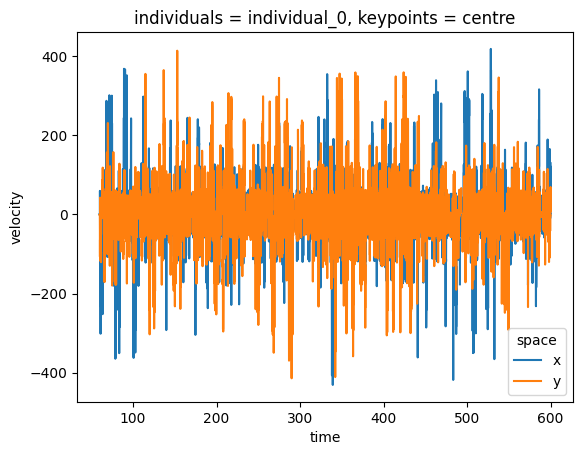

In [52]:
centre_velocity = ds_sleap_video1.velocity.sel(
    individuals="individual_0",
    keypoints="centre",
    time=slice(1 * 60, 10 * 60),
)
centre_velocity.plot.line(x="time", hue="space")

Speed can be defined as the magnitude (norm) of the velocity vector.

In [53]:
centre_speed = compute_norm(centre_velocity)
centre_speed

<xarray.DataArray 'velocity' (time: 16201)> Size: 65kB
1.578 3.19 3.19 0.0 0.3397 0.7767 0.6949 ... 93.11 95.27 133.8 105.7 80.96 140.2
Coordinates:
  * time         (time) float64 130kB 60.0 60.03 60.07 ... 599.9 600.0 600.0
    individuals  <U12 48B 'individual_0'
    keypoints    <U9 36B 'centre'

Visualise speed (in px/s) over time for the `centre` keypoint.

Text(0, 0.5, 'speed (pixels/s)')

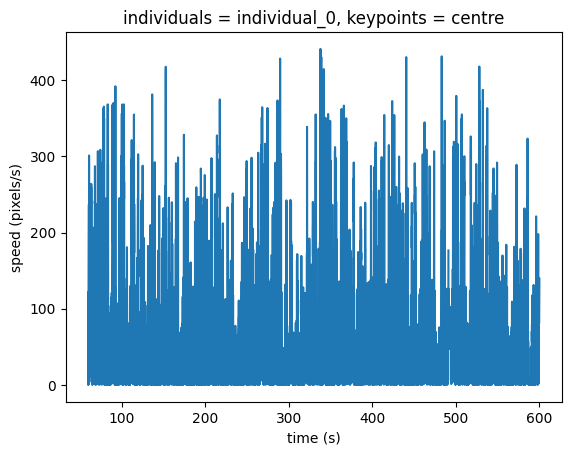

In [54]:
centre_speed.plot.line(x="time")
plt.xlabel("time (s)")
plt.ylabel("speed (pixels/s)")